# Extract outbreak polygons

This script takes the preprocessed ADS data that was clipped to the MNF boundaries and extracts only the WSB polygons from survey years 1965-1990. It then dissolves the boundaries between polygons of the same year so each year's survey data is represented and visualized as a single polygon. The plots at the end (and the widget if it works in your browser) show the progression of the Malheur outbreaks over the 1980s.

## Import packages

In [1]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display
import contextily as ctx

## Extract WSB outbreak polygons from ADS data

In [2]:
# File paths
all_damage_areas_path = r"../subsetted_data/mnf_damage_1965_1990.geojson"
mnf_bounds_path = r"../subsetted_data/malheur_bounds.geojson"

# Output folder
dissolved_output_folder = r"../script_outputs/ads_dissolved"
os.makedirs(dissolved_output_folder, exist_ok=True)

In [3]:
# Read and prepare layers
damage_areas = gpd.read_file(all_damage_areas_path).to_crs(epsg = 3857)
mnf_bounds = gpd.read_file(mnf_bounds_path).to_crs(damage_areas.crs)  # Match CRS

In [4]:
damage_areas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13624 entries, 0 to 13623
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   DAMAGE_AREA_ID           13624 non-null  object  
 1   CREATED_DATE             0 non-null      object  
 2   MODIFIED_DATE            0 non-null      object  
 3   FEATURE_USER_ID          0 non-null      object  
 4   OBSERVATION_USER_ID      0 non-null      object  
 5   REGION_ID                13624 non-null  int32   
 6   LABEL                    0 non-null      object  
 7   HOST_CODE                13624 non-null  float64 
 8   HOST                     11038 non-null  object  
 9   HOST_GROUP_CODE          13624 non-null  float64 
 10  HOST_GROUP               1093 non-null   object  
 11  DCA_CODE                 13624 non-null  int32   
 12  DCA_COMMON_NAME          13624 non-null  object  
 13  DAMAGE_TYPE_CODE         13624 non-null  float64 
 14

"damage_areas" contains all data collected by the aerial detection survey for all of USFS Region 6 (Washington and Oregon) for all years collected (dating back to the 1940s) and all potential causes of damage (e.g., different pests, fire, other disturbances). We want to focus in on the western spruce budworm (DCA code "12040") outbreaks of the 1980s in Malheur National Forest. To ensure we aren't missing important data, we'll include the 15 years prior to the 1980s outbreaks as the effects of some outbreaks could affect later fire behavior even 20 years later. 

In [5]:
# Filter out damage causes other than WSB
wsb_damage_areas = damage_areas.loc[damage_areas["DCA_CODE"] == 12040]

# Double check outbreaks are prior to 1965 and after 1990
wsb_damage_areas = wsb_damage_areas[(wsb_damage_areas["SURVEY_YEAR"] >= 1965) & (wsb_damage_areas["SURVEY_YEAR"] <= 1990)] 

len(wsb_damage_areas)

1070

There were 1070 recorded WSB outbreak polygons from 1965-1990 in MNF.

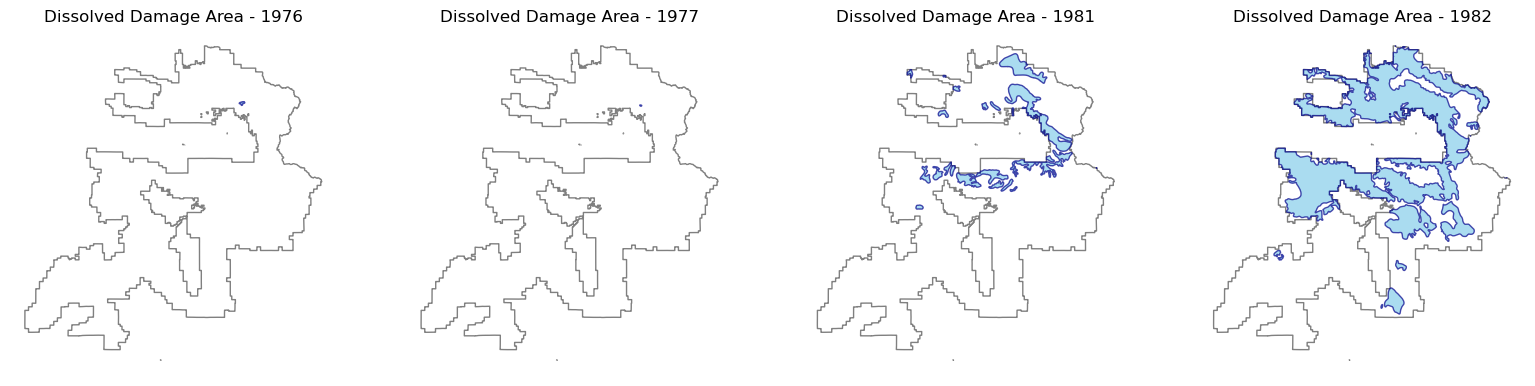

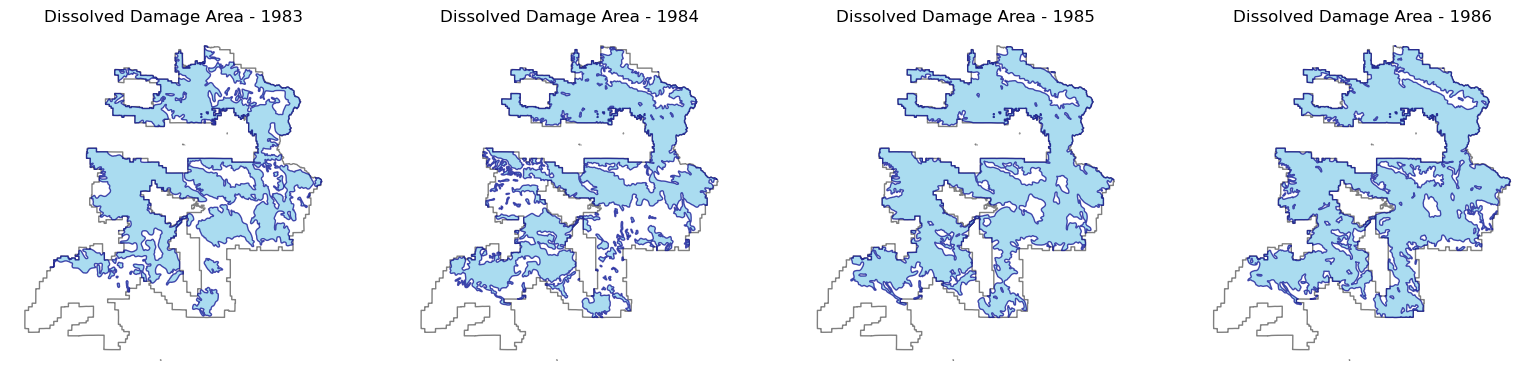

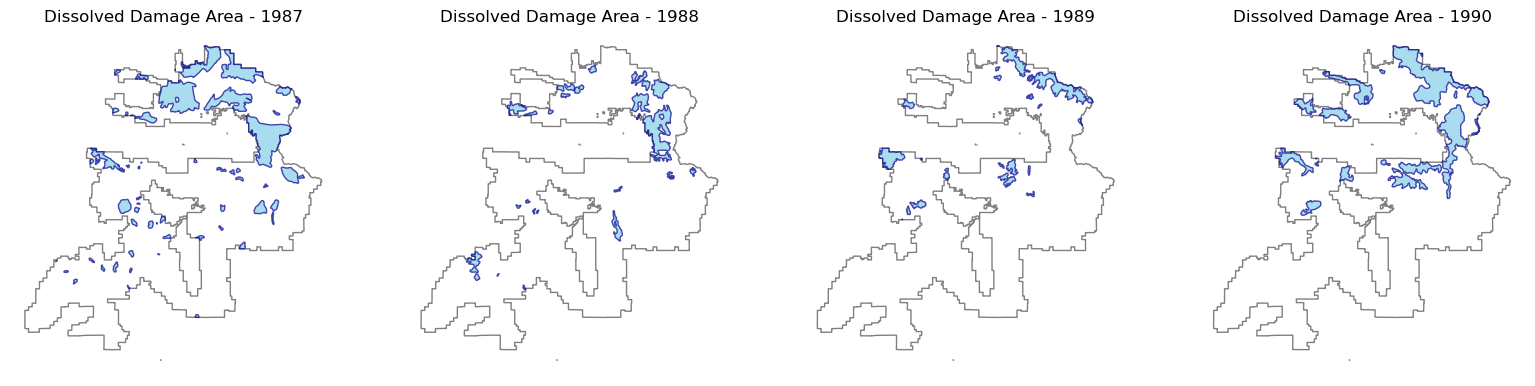

In [6]:
# Reproject MNF bounds if necessary to match CRS
if mnf_bounds.crs != wsb_damage_areas.crs:
    mnf_bounds = mnf_bounds.to_crs(wsb_damage_areas.crs)

# Get unique years
unique_years = sorted(wsb_damage_areas["SURVEY_YEAR"].dropna().unique())

# Determine number of rows needed (each row contains 4 plots)
num_rows = math.ceil(len(unique_years) / 4)

# Iterate through all years, grouping them in sets of four per row
for row in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Each row has 4 plots

    for i in range(4):
        year_index = row * 4 + i  # Calculate correct year index
        if year_index >= len(unique_years):
            break  # Stop if we exceed available years

        year = unique_years[year_index]
        try:
            yearly_data = wsb_damage_areas[wsb_damage_areas["SURVEY_YEAR"] == year]

            if yearly_data.empty:
                print(f"No data for year {year}, skipping.")
                continue

            # Dissolve geometries
            dissolved = yearly_data.dissolve(by="SURVEY_YEAR").reset_index()

            # Plot with MNF boundary in background
            mnf_bounds.plot(ax=axes[i], facecolor='none', edgecolor='gray', linewidth=1)
            dissolved.plot(ax=axes[i], facecolor='skyblue', edgecolor='darkblue', alpha=0.7)

            axes[i].set_title(f"Dissolved Damage Area - {int(year)}", fontsize=12)
            axes[i].set_axis_off()

            # Export to GeoJSON
            output_path = os.path.join(dissolved_output_folder, f"damage_{int(year)}_dissolved.geojson")
            dissolved.to_file(output_path, driver="GeoJSON")

        except Exception as e:
            print(f"Error processing year {year}: {e}")

    plt.tight_layout()
    plt.show()  # Show each row separately


While there were small outbreaks in 1976 and 1977, the beginning of the pervasive outbreaks highlighted in the Powell report are clear in the 1981 plot after a few years with no WSB outbreaks. 1985 and 1986 appear to be the height of the outbreaks in terms of area covered, which is consistent with Powell's observations. The outbreaks technically continue until 1993, but they were winding down by 1990 when the Powell report fires occurred.

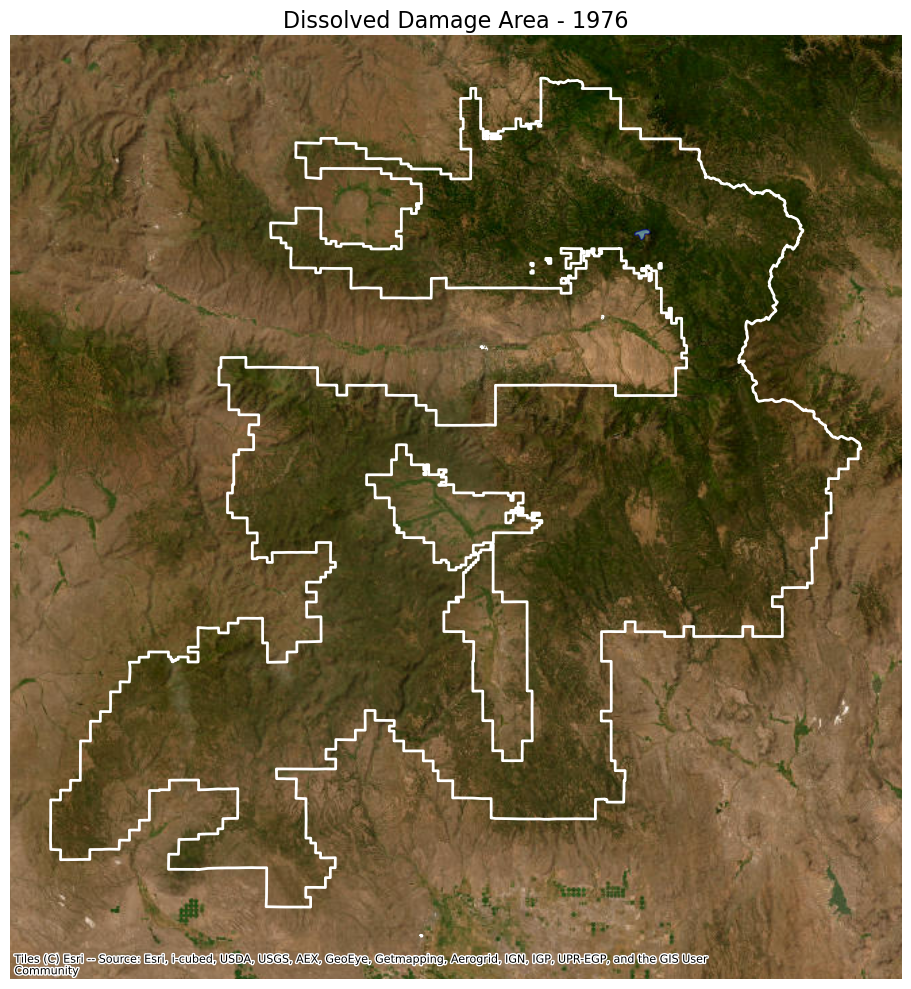

In [7]:
## This widget was working on one of my computers but threw a browser error on another. It's just another visualization of the same plots as above.
# Reproject to Web Mercator
mnf_bounds_web = mnf_bounds.to_crs(epsg=3857)
wsb_damage_areas_web = wsb_damage_areas.to_crs(epsg=3857)

# Prepare available years
years = sorted(wsb_damage_areas_web["SURVEY_YEAR"].dropna().unique())

# Create the year slider
year_slider = widgets.IntSlider(
    value=int(min(years)),
    min=int(min(years)),
    max=int(max(years)),
    step=1,
    description='Year:',
    continuous_update=False
)

# Output area
output = widgets.Output()

# Define the plotting function
def plot_year(change):
    year = change['new']
    output.clear_output(wait=True)
    with output:
        yearly_data = wsb_damage_areas_web[wsb_damage_areas_web["SURVEY_YEAR"] == year]
        if yearly_data.empty:
            print(f"No data for {year}")
            return
        dissolved = yearly_data.dissolve(by="SURVEY_YEAR").reset_index()
        fig, ax = plt.subplots(figsize=(10, 10))
        dissolved.plot(ax=ax, facecolor='skyblue', edgecolor='darkblue', alpha=0.6)
        mnf_bounds_web.boundary.plot(ax=ax, edgecolor='white', linewidth=2)
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
        ax.set_title(f"Dissolved Damage Area - {int(year)}", fontsize=16)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

# Link the slider to the plotting function
year_slider.observe(plot_year, names='value')

# Display the widget and output
display(widgets.VBox([year_slider, output]))

# Trigger initial display
plot_year({'new': year_slider.value})